## Closed Loop Simulation Notebook

This notebook breaks down the closed loop simulation in different jupyter notebook cells. The aim of this notebook is to ease the debugging and development of the different packages involved in the Optical Feedback Control loop.

This notebook was last run on July 7th 2022. 
Details:
- Stack release: 2021_25, Last verified to run 2022-07-07
- ts_phosim release: v2.0.4


### Required python packages

In [1]:
import argparse
import logging
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from lsst.ts.phosim.CloseLoopTask import CloseLoopTask
from lsst.ts.phosim.telescope.TeleFacade import TeleFacade
from lsst.ts.phosim.utils.PlotUtil import plotFwhmOfIters
from lsst.daf import butler as dafButler
from lsst.ts.wep.Utility import CamType, FilterType, runProgram
from lsst.ts.phosim.utils.Utility import getPhoSimPath, getAoclcOutputPath, getCamera
from lsst.ts.phosim.utils.SensorWavefrontError import SensorWavefrontError

In [2]:
from tqdm import tqdm

### Default arguments and initializations

Initialize default arguments to run the closed loop and initialize the ClosedLoopTask

In [3]:
%%time

# Set the parser
parser = argparse.ArgumentParser(
    description="Run AOS closed-loop simulation (default is amplifier files)."
)
parser = CloseLoopTask.setDefaultParser(parser)
parser = CloseLoopTask.setImgParser(parser)

# Get the default arguments
sys.argv = ['-f']
args = parser.parse_args()

# Print default arguments
print(args)

logger = logging.getLogger()
logger.setLevel(args.log_level)

# Initialize the ClosedLoopTask
closeLoopTask = CloseLoopTask()

Namespace(inst='comcam', filterType='', rotCam=0.0, m1m3FErr=0.05, numOfProc=1, iterNum=5, output='', log_level=20, clobber=False, pipelineFile='', boresightDeg=[0, 0], skyFile='', eimage=False)
CPU times: user 4.75 ms, sys: 299 µs, total: 5.05 ms
Wall time: 3.97 ms


### Set paths and arguments

Customize the following arguments to run the simulation you are interested in. If not stated in the following code cell, the arguments are taken to be the default ones. Note that this paths should be changed if another user is running them and wants to change the directory addresses.

In [4]:
PHOSIMPATH = "/home/gmegias/jhome/aos/phosim_syseng4/"
AOCLCOUTPUTPATH = "/home/gmegias/jhome/aos/ts_phosim/output/"
os.environ["PHOSIMPATH"] = PHOSIMPATH
os.environ["AOCLCOUTPUTPATH"] = AOCLCOUTPUTPATH

In [5]:
args.inst = 'comcam' 
args.numOfProc = 32 
args.boresightDeg = [0.03, -0.02]
args.eimage = None
args.skyFile = '/home/gmegias/jhome/aos/ts_phosim/tests/testData/sky/skyComCam.txt'
args.output = '/home/gmegias/jhome/aos/perturbations/test0/'

if os.path.exists(args.output):
    shutil.rmtree(args.output)

### Intializations and initial configurations

First, initialize the variables from the arguments dictionary.

In [6]:
boresight = args.boresightDeg
rotCamInDeg = args.rotCam
useEimg = args.eimage
m1m3ForceError = args.m1m3FErr
numPro = args.numOfProc
iterNum = args.iterNum
doErsDirCont = args.clobber
pathSkyFile = args.skyFile

In [24]:
%%time

# Check the input arguments
camType, instName = closeLoopTask.getCamTypeAndInstName(args.inst)
filterType = closeLoopTask.getFilterType(args.filterType)
baseOutputDir = closeLoopTask.checkAndCreateBaseOutputDir(args.output)

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.08 ms


In [29]:
%%time
closeLoopTask.configPhosimCmpt(
    filterType, rotCamInDeg, m1m3ForceError, numPro, boresight=boresight
)

CPU times: user 2min 58s, sys: 2.6 s, total: 3min 1s
Wall time: 3min 1s


Check and set the required configurations to run the simulation loop.

In [7]:
%%time

# Check the input arguments
camType, instName = closeLoopTask.getCamTypeAndInstName(args.inst)
filterType = closeLoopTask.getFilterType(args.filterType)
baseOutputDir = closeLoopTask.checkAndCreateBaseOutputDir(args.output)

if doErsDirCont:
    closeLoopTask.eraseDirectoryContent(baseOutputDir)

closeLoopTask.checkBoresight(boresight, args.skyFile)

closeLoopTask.assignImgType(useEimg)

# Configure the components
closeLoopTask.configSkySim(instName, pathSkyFile = args.skyFile, starMag=15)

# If pathSkyFile using default OPD positions write this to disk
# so that the Butler can load it later
if pathSkyFile == "":
    pathSkyFile = os.path.join(baseOutputDir, "sky_info.txt")
    closeLoopTask.skySim.exportSkyToFile(pathSkyFile)
    closeLoopTask.log.info(f"Wrote new sky file to {pathSkyFile}.")

closeLoopTask.configOfcCalc(instName)
closeLoopTask.configPhosimCmpt(
    filterType, rotCamInDeg, m1m3ForceError, numPro, boresight=boresight
)

CPU times: user 2min 50s, sys: 1.84 s, total: 2min 52s
Wall time: 2min 52s


### Generate butler gen3 repository.

In [8]:
%%time

# generate bluter gen3 repo if needed
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
if closeLoopTask.useCcdImg():
    closeLoopTask.generateButler(butlerRootPath, instName)
    closeLoopTask.generateRefCatalog(
        instName = instName,
        butlerRootPath = butlerRootPath,
        pathSkyFile = pathSkyFile,
    )
    
closeLoopTask.phosimCmpt.tele.setInstName(camType)

CPU times: user 88 µs, sys: 0 ns, total: 88 µs
Wall time: 98 µs


### Simulation loop initialization

Initialize the state of the telescope to run the simulation. This cell also sets common file and directory names required for the closed loop simulation.

In [9]:
# Set the telescope state to be the same as the OFC
state0 = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(state0)

In [10]:
print(state0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [13]:
# Set the telescope state to be the same as the OFC
state0 = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(state0)

# Get the list of referenced sensor name (field positions)

# If using wavefront sensors we measure one per pair
# and the field
if camType == CamType.LsstCam:
    cornerSensorNameList = closeLoopTask.getSensorNameListOfFields(instName)
    cornerSensorIdList = closeLoopTask.getSensorIdListOfFields(instName)
    refSensorNameList = []
    refSensorIdList = []
    for name, id in zip(cornerSensorNameList, cornerSensorIdList):
        if name.endswith("SW0"):
            refSensorNameList.append(name)
            refSensorIdList.append(id)
else:
    refSensorNameList = closeLoopTask.getSensorNameListOfFields(instName)
    refSensorIdList = closeLoopTask.getSensorIdListOfFields(instName)

# Get the list of referenced sensor name (field positions)
refSensorNameList = closeLoopTask.getSensorNameListOfFields(instName)
refSensorIdList = closeLoopTask.getSensorIdListOfFields(instName)

# Common file and directory names
opdZkFileName = "opd.zer"
opdPssnFileName = "PSSN.txt"
outputDirName = "pert"
outputImgDirName = "img"
iterDefaultDirName = "iter"
dofInUmFileName = "dofPertInNextIter.mat"
fwhmItersFileName = "fwhmIters.png"
if args.pipelineFile == "":
    pipelineFile = None

# Specific file names to the amplifier/eimage
wfsZkFileName = "wfs.zer"

In [16]:
iterCount = 2
obsId = 9006000
# Set the observation Id
closeLoopTask.phosimCmpt.setSurveyParam(obsId=obsId)

# The iteration directory
iterDirName = "%s%d" % (iterDefaultDirName, iterCount)

# Set the output directory
outputDir = os.path.join(baseOutputDir, iterDirName, outputDirName)
closeLoopTask.phosimCmpt.setOutputDir(outputDir)

# Set the output image directory
outputImgDir = os.path.join(baseOutputDir, iterDirName, outputImgDirName)
closeLoopTask.phosimCmpt.setOutputImgDir(outputImgDir)

In [17]:
# Generate the OPD image
print("Preparing PhoSim....")
t0 = time.time()
argString = closeLoopTask.phosimCmpt.getOpdArgsAndFilesForPhoSim(instName)
closeLoopTask.log.info(f"PHOSIM OPD ARGSTRING: {argString}")
ttl_time = time.time() - t0
print("PhoSim prepared, took {} seconds.".format(ttl_time))

Preparing PhoSim....
PhoSim prepared, took 118.119056224823 seconds.


In [18]:
print("Running PhoSim....")
t0 = time.time()
closeLoopTask.phosimCmpt.runPhoSim(argString)
ttl_time = time.time() - t0
print("PhoSim run, took {} seconds.".format(ttl_time))

Running PhoSim....
PhoSim run, took 87.57975053787231 seconds.


In [19]:
# Analyze the OPD data
# Rotate OPD in the reversed direction of camera
print("Analyzing OPD data....")
t0 = time.time()
closeLoopTask.phosimCmpt.analyzeOpdData(
    instName,
    zkFileName=opdZkFileName,
    rotOpdInDeg=-rotCamInDeg,
    pssnFileName=opdPssnFileName,
)
ttl_time = time.time() - t0
print("OPD data analyzed, took {} seconds.".format(ttl_time))

Analyzing OPD data....
OPD data analyzed, took 0.9558737277984619 seconds.


In [20]:
# Get the PSSN from file
pssn = closeLoopTask.phosimCmpt.getOpdPssnFromFile(opdPssnFileName)
print("Calculated PSSN is %s." % pssn)

# Get the GQ effective FWHM from file
gqEffFwhm = closeLoopTask.phosimCmpt.getOpdGqEffFwhmFromFile(opdPssnFileName)
print("GQ effective FWHM is %.4f." % gqEffFwhm)

# Set the FWHM data
print("Setting FWHM data...")
t0 = time.time()
fwhm, sensor_id = closeLoopTask.phosimCmpt.getListOfFwhmSensorData(
    opdPssnFileName, refSensorIdList
)

closeLoopTask.ofcCalc.set_fwhm_data(fwhm, sensor_id)
ttl_time = time.time() - t0
print("FWHM data set, took {} seconds.".format(ttl_time))

Calculated PSSN is [0.63056132 0.61835185 0.5947528  0.62761458 0.6140287  0.59458357
 0.62268922 0.61750366 0.60180361].
GQ effective FWHM is 0.5172.
Setting FWHM data...
FWHM data set, took 0.0017588138580322266 seconds.


### Define Wavefront Estimation functions

This re-definitiion is required to ensure WEP files are created in the correct directory.

In [21]:
%%time
# Generate the sky images and calculate the wavefront error
if closeLoopTask.useCcdImg():
    if camType == CamType.LsstCam:
        listOfWfErr = closeLoopTask._calcWfsWfErrFromImg(
            obsId,
            butlerRootPath=butlerRootPath,
            instName=instName,
            snap=0,
            numPro=numPro,
            pipelineFile=pipelineFile,
        )
    else:
        listOfWfErr = closeLoopTask._calcPistonWfErrFromImg(
            obsId,
            butlerRootPath=butlerRootPath,
            instName=instName,
            snap=0,
            numPro=numPro,
            pipelineFile=pipelineFile,
        )
else:
    # Simulate to get the wavefront sensor data from WEP
    listOfWfErr = closeLoopTask.phosimCmpt.mapOpdDataToListOfWfErr(
        opdZkFileName, refSensorIdList, refSensorNameList
    )

CPU times: user 1.87 ms, sys: 1.69 ms, total: 3.56 ms
Wall time: 2.33 ms


In [23]:
listOfWfErr

for sensor_wfe in listOfWfErr:
    print(sensor_wfe)

### Record the wavefront error and save

In [46]:
# Record the wavefront error with the same order as OPD for the
# comparison
print('Recording wavefront error...')
t0 = time.time()
if closeLoopTask.useCcdImg():
    closeLoopTask.phosimCmpt.reorderAndSaveWfErrFile(
        listOfWfErr,
        refSensorNameList,
        getCamera(instName),
        zkFileName=wfsZkFileName,
    )
ttl_time = time.time() - t0
print('Wavefront error recorded. Took {} seconds.'.format(ttl_time))

# Calculate the DOF
print('Calculating DOF...')
t0 = time.time()
wfe = np.array(
    [sensor_wfe.getAnnularZernikePoly() for sensor_wfe in listOfWfErr]
)
sensor_ids = np.array(
    [sensor_wfe.getSensorId() for sensor_wfe in listOfWfErr]
)
ttl_time = time.time() - t0
print('DOF computed. Took {} seconds.'.format(ttl_time))

print('Calculating corrections...')
t0 = time.time()
closeLoopTask.ofcCalc.calculate_corrections(
    wfe=wfe,
    field_idx=sensor_ids,
    filter_name=str('R'),
    gain=-1,
    rot=rotCamInDeg,
)
ttl_time = time.time() - t0
print('Corrections computed. Took {} seconds.'.format(ttl_time))

# Set the new aggregated DOF to phosimCmpt
print('Setting and saving new DOF...')
t0 = time.time()
dofInUm = closeLoopTask.ofcCalc.ofc_controller.aggregated_state
closeLoopTask.phosimCmpt.setDofInUm(dofInUm)

# Save the DOF file
closeLoopTask.phosimCmpt.saveDofInUmFileForNextIter(
    dofInUm, dofInUmFileName=dofInUmFileName
)
ttl_time = time.time() - t0
print('New DOF saved. Took {} seconds.'.format(ttl_time))

# Add the observation ID by 10 for the next iteration
obsId += 10

Recording wavefront error...
Wavefront error recorded. Took 0.0002167224884033203 seconds.
Calculating DOF...
DOF computed. Took 0.00042176246643066406 seconds.
Calculating corrections...
Corrections computed. Took 0.017017126083374023 seconds.
Setting and saving new DOF...
New DOF saved. Took 0.0020003318786621094 seconds.


The wavefront error of the first simulation iteration is printed below

### Summarize the FWHM and plot results

In [47]:
# Summarize the FWHM
pssnFiles = [
    os.path.join(
        baseOutputDir,
        "%s%d" % (iterDefaultDirName, num),
        outputImgDirName,
        opdPssnFileName,
    )
    for num in [0,1,2]
]
saveToFilePath = os.path.join(baseOutputDir, fwhmItersFileName)
plotFwhmOfIters(pssnFiles, saveToFilePath=saveToFilePath)

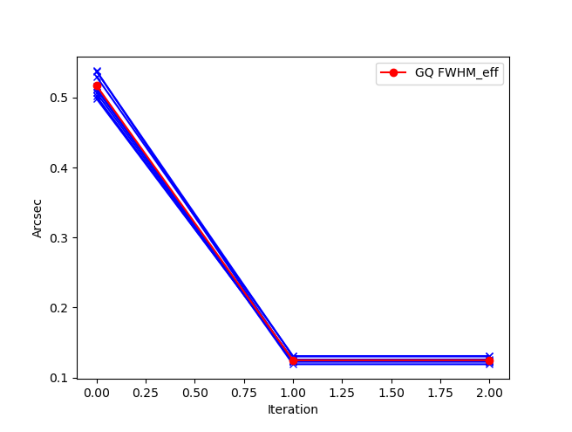

In [71]:
# importing Image class from PIL package
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

im = np.array(Image.open(saveToFilePath))
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.axis('off')
plt.show()
